Use medium image to train the neural network.

In [18]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  6 15:14:16 2022

@author: zhuch
"""

# -*- coding: utf-8 -*-
"""
Created on Thu May  5 17:30:53 2022

@author: zhuch
"""

import pickle

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt


#%%

# with open("speckle.dat", 'rb') as f:
#     input_list = pickle.load(f)

# with open("SLM.dat", 'rb') as f:
#     output_list =pickle.load(f)
    
#%%

with open("data/medium_10238.dat", 'rb') as f:
    medium_pred = pickle.load(f)

with open("data/experiment results/Natural_10238.dat", 'rb') as f:
    output_list =pickle.load(f)

#%%
# s = input_list[5]
# x = np.arange(0,112,1)
# y = np.arange(0,112,1)
# X,Y = np.meshgrid(x,y)
# plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(X,Y,s.reshape(112,112), cmap='viridis')
# # plt.colorbar()
# plt.show()

#%%
N_sample = 10000
train_rate = 0.9
train_set_number = int(train_rate*N_sample)

input_dim = (64,64)

input_H = np.array(medium_pred).reshape(-1,1, *input_dim)
label = np.array(output_list).reshape(-1,1, 64, 64)

train_number = np.arange(0,N_sample, dtype ='int')
np.random.shuffle(train_number)

x_train = input_H[train_number[0:train_set_number]]
x_test = input_H[train_number[train_set_number:N_sample]]

y_train =label[train_number[0:train_set_number]]
y_test = label[train_number[train_set_number:N_sample]]

x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)

y_train = torch.FloatTensor(y_train/256.0)
y_test = torch.FloatTensor(y_test/256.0)
    
    
batch_size = 100

# create data loaders
train_dataloader = DataLoader(list(zip(x_train, y_train)), batch_size = batch_size )
test_dataloader = DataLoader(list(zip(x_test,y_test)),  batch_size = batch_size )

#%%
del medium_pred
del output_list
del input_H
del label
#%%
torch.cuda.empty_cache()
#%%
device = "cuda"
import torch.nn.functional as F

# Nnodes = 4096

# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(112*112, Nnodes)
#         self.fc2 = nn.Linear(Nnodes, 64*64)
#         self.dp = nn.Dropout(0.3)
#         self.BN = nn.BatchNorm1d(Nnodes)
#         self.BN2 = nn.BatchNorm1d(64*64)  
#         self.flatten = nn.Flatten()
        
#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.BN(self.dp(F.relu(self.fc1(x))))
#         x = self.BN2(self.dp(F.sigmoid(self.fc2(x))))
#         # x = self.dp(F.relu(self.fc2(x)))
#         x = x.view(-1,1,64,64)
#         return x

# model = NeuralNetwork().to(device)
# from torchsummary import summary
# summary(model, (1, 112, 112))

#%%
# Define model
Nnodes = 2048

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(64*64, Nnodes)
        self.fc2 = nn.Linear(Nnodes, 64*64)
        self.dp = nn.Dropout(0.2)
        self.BN = nn.BatchNorm1d(Nnodes)
        self.BN2 = nn.BatchNorm1d(64*64)  
        self.BN3 = nn.BatchNorm2d(10)  
        self.ct1 = nn.ConvTranspose2d(1,10,2,stride = 2)
        self.ct2 = nn.ConvTranspose2d(10,6,2,stride = 2)
        
        self.conv2 = nn.Conv2d(6,1,3)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc3 = nn.Linear(3969, 64*64)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.BN(self.dp(F.leaky_relu(self.fc1(x))))
        x = self.BN2(self.dp(F.sigmoid(self.fc2(x))))
        x = x.view(-1,1,64,64)
        # x = F.relu(self.ct1(x))
        # x = F.relu(self.ct2(x))
        # x = self.pool(self.conv2(x))
        # x = self.flatten(x)
        # x = self.dp(F.leaky_relu(self.fc3(x)))
        # x = x.view(-1,1,64,64)
        return x

# model = NeuralNetwork().to(device)
# from torchsummary import summary
# summary(model, (1, 64, 64))

#%%

import torchvision
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(1,64,128)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(1,64,128), dec_chs=( 128, 64), num_class=1, retain_dim=True, out_sz=(64,64)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz =  out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out
    
model = UNet().to(device)
from torchsummary import summary
summary(model, (1, 64, 64))

#%%
import ssim
loss_fn = ssim.SSIM()

from torch.optim.lr_scheduler import ReduceLROnPlateau
# loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss.cpu().detach().numpy()
            
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Loss:  {test_loss:>8f} \n")
    return test_loss
    
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]             640
              ReLU-2           [-1, 64, 62, 62]               0
            Conv2d-3           [-1, 64, 60, 60]          36,928
             Block-4           [-1, 64, 60, 60]               0
         MaxPool2d-5           [-1, 64, 30, 30]               0
            Conv2d-6          [-1, 128, 28, 28]          73,856
              ReLU-7          [-1, 128, 28, 28]               0
            Conv2d-8          [-1, 128, 26, 26]         147,584
             Block-9          [-1, 128, 26, 26]               0
        MaxPool2d-10          [-1, 128, 13, 13]               0
          Encoder-11  [[-1, 64, 60, 60], [-1, 128, 26, 26]]               0
  ConvTranspose2d-12           [-1, 64, 52, 52]          32,832
           Conv2d-13           [-1, 64, 50, 50]          73,792
             ReLU-14       

In [32]:
# import gc

# gc.collect()

# torch.cuda.empty_cache()
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 9            |        cudaMalloc retries: 14        |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  737493 KB |     966 MB |    2677 GB |    2676 GB |\n|       from large pool |  731192 KB |     965 MB |    2631 GB |    2631 GB |\n|       from small pool |    6301 KB |       7 MB |      45 GB |      45 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  737493 KB |     966 MB |    2677 GB |    2676 GB |\n|       from large pool |  731192 KB |     965 MB |

In [31]:
#%%  Neural network training


epochs = 50

Loss_train = []
Loss_test = []
steps = []

best_loss = 1.0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    Loss_train.append(train_loss)
    Loss_test.append(test_loss)
    if test_loss<best_loss:
        best_loss = test_loss
    steps.append(t)
    scheduler.step(test_loss)
print("Done!")    
    

# %%
plt.figure(figsize = (8,6))
plt.title("MSE Loss vs Epochs")
plt.plot(steps, Loss_train, label = 'train')
plt.plot(steps, Loss_test, label = 'test')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()
        
#%%
torch.cuda.empty_cache()
#%%


#%%
# figure configuration
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


Epoch 1
-------------------------------
Train loss: 1.055530  [    0/ 9000]


RuntimeError: CUDA out of memory. Tried to allocate 62.00 MiB (GPU 0; 19.62 GiB total capacity; 776.46 MiB already allocated; 60.75 MiB free; 940.00 MiB reserved in total by PyTorch)

In [8]:
torch.save(model.state_dict(), 'model/exp_medium.dat')

#%%  test model

test_model = NeuralNetwork().to('cpu')

test_model.load_state_dict(torch.load('model/exp_medium.dat'))

<All keys matched successfully>

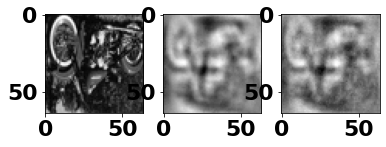

In [17]:
#%%
test_number = np.random.randint(0,200)

with torch.no_grad():
    test_model.eval()
    X= x_test[test_number].reshape(-1,1,*input_dim)
    pred = test_model(X)
plt.figure() 
plt.subplot(131)
plt.imshow(y_test[test_number].reshape(64,64), cmap = 'gray')  
plt.subplot(132)
plt.imshow(pred[0].reshape(64,64), cmap = 'gray')
# plt.imshow(pred[0].reshape(64,64))
plt.subplot(133)
plt.imshow(X.reshape(64,64), cmap = 'gray')
# plt.imshow(pred[0].reshape(64,64))
plt.show()
#%%
# test_number = np.random.randint(0,500)

# with torch.no_grad():
#     test_model.eval()
#     X = x_train[test_number].reshape(-1,1, *input_dim)
#     pred = test_model(X)
  
# plt.figure() 
# plt.subplot(121)
# plt.imshow(y_train[test_number].reshape(64,64), cmap = 'gray')  
# plt.subplot(122)
# plt.imshow(pred[0].reshape(64,64), cmap = 'gray')
# plt.show()